In [28]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import pandas as pd

from utils import train_jp, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, plotmesh, merge_weights_aniso
from utils_node import NODE, init_layers

import GPy
from jaxinterp2d import interp2d

from scipy.optimize import fsolve

In [2]:
n = 20
x_gt = np.linspace(0,1,n)[:,None]
k = GPy.kern.RBF(input_dim=1,lengthscale=0.4)
mu = np.zeros((n)) 
C = k.K(x_gt,x_gt) 
eps_gt = np.random.multivariate_normal(mu,C,1)*0.03+0.15

x_gt = x_gt.flatten()
eps_gt = eps_gt.flatten()

Fx = np.random.uniform()+0.5

Text(0.5, 1.0, 'Reaction force = 0.623')

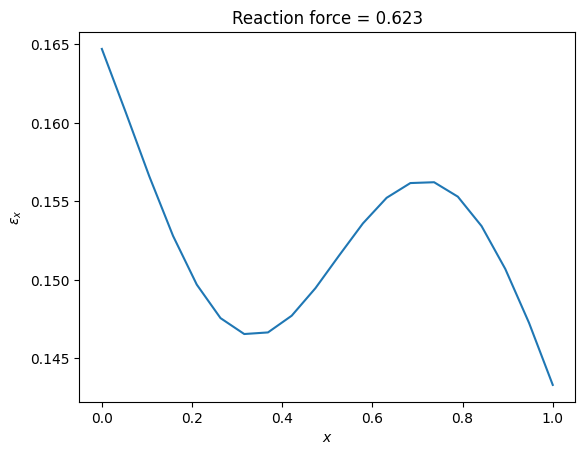

In [3]:
plt.plot(x_gt,eps_gt)
plt.xlabel('$x$')
plt.ylabel('$\epsilon_{x}$')
plt.title('Reaction force = {}'.format(np.round(Fx, 3)))

### Incompressible neo-Hookean

$$ \Psi(\mathbf{F}, x) = \mu(x)(I_1(x)-3) $$

$$ \boldsymbol{\sigma} = -p\mathbf{I} + \mu \mathbf{b} $$

under uniaxial loading $\lambda_y = \lambda_z = 1/\sqrt{\lambda}, \lambda_x = \lambda$ and $\mathbf{b} = \mathrm{diag}(\lambda^2, 1/\lambda, 1/\lambda)$ then,

$$ p = \frac{\mu}{\lambda} $$ 

from boundary conditions. And finally,

$$ \sigma_{xx} = \mu \lambda^2 - \frac{\mu}{\lambda} $$

In [4]:
def nn_fpass(H, params):
    Ws, bs = params
    N_layers = len(Ws)
    for i in range(N_layers - 1):
        H = jnp.matmul(H, Ws[i]) + bs[i]
        H = jnp.tanh(H)
    H = jnp.matmul(H, Ws[-1]) + bs[-1]
    return H

def init_params_nn(layers, key):
    Ws = []
    bs = []
    for i in range(len(layers) - 1):
      std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
      key, subkey = random.split(key)
      Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
      bs.append(jnp.zeros(layers[i + 1]))
    return [Ws, bs]
    
def get_stress_neoHook(x, Lambda_params):
    eps = jnp.interp(x, x_gt, eps_gt)
    lmb = 1.0+eps
    mu = nn_fpass(x, Lambda_params)
    sgmx = mu*lmb**2 - mu/lmb
    return sgmx[0]
get_stress_neoHook_vmap = vmap(get_stress_neoHook, in_axes=(0,None), out_axes=(0,))

### Loss function: 2 objectives
#### 1. Balance of linear momentum

$$ \nabla \cdot \boldsymbol{\sigma} + \rho \mathbf{f} = 0 $$

in the absence of body forces $\mathbf{f}$ and in 1D this becomes

$$ \frac{\partial \sigma_{xx}}{\partial x} = 0 $$


#### 2. Satisfying reaction forces

$$ \int_{\text{bd}} \sigma_{xx} dA = F_{\text{react.}} $$

Then the loss function is defined as

$$ L(\phi) = \left( \frac{\partial \sigma_{xx}}{\partial x} \right)^2 + (\sigma_{xx}(0) \cdot A - F_{\text{react.}})^2 + (\sigma_{xx}(L) \cdot A - F_{\text{react.}})^2 $$

In [22]:
divergence_1d = vmap(grad(get_stress_neoHook, argnums=0), in_axes=(0,None), out_axes=0)

def loss(Lambda_params, input, key):
    # get divergence across the domain
    x_colloc = random.uniform(key, (20,1))
    div = divergence_1d(x_colloc, Lambda_params)

    # get stress at 0 & L
    sgm0 = get_stress_neoHook(x_gt[ 0,None], Lambda_params)
    sgmL = get_stress_neoHook(x_gt[-1,None], Lambda_params)
    return 1*jnp.sum(div**2) + 10*((sgm0*1 - Fx)**2 + (sgmL*1-Fx)**2) # Assuming CS Area = 1


Lambda_layers = [1,3,3,1]
key = random.PRNGKey(0)
Lambda_params = init_params_nn(Lambda_layers, key)

opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Lambda_params)

Lambda_params, train_loss, metrics = train_jp(loss, None, get_params, opt_update, opt_state, key, nIter = 1000000, print_freq=10000)

it 10000, train loss = 3.912903e+00
it 20000, train loss = 1.252565e+00
it 30000, train loss = 5.417993e-01
it 40000, train loss = 3.626258e-01
it 50000, train loss = 2.315112e-01
it 60000, train loss = 3.171430e-01
it 70000, train loss = 2.562894e-01
it 80000, train loss = 1.890318e-01
it 90000, train loss = 1.221381e-01
it 100000, train loss = 1.478361e-01
it 110000, train loss = 7.044612e-02
it 120000, train loss = 9.243809e-02
it 130000, train loss = 2.974776e-02
it 140000, train loss = 2.265646e-02
it 150000, train loss = 7.152500e-03
it 160000, train loss = 1.007680e-02
it 170000, train loss = 7.239181e-03
it 180000, train loss = 9.098463e-03
it 190000, train loss = 5.361976e-03
it 200000, train loss = 1.151774e-02
it 210000, train loss = 8.127846e-03
it 220000, train loss = 9.411984e-03
it 230000, train loss = 5.267475e-03
it 240000, train loss = 9.288228e-03
it 250000, train loss = 1.098916e-02
it 260000, train loss = 1.046880e-02
it 270000, train loss = 4.331196e-03
it 280000,

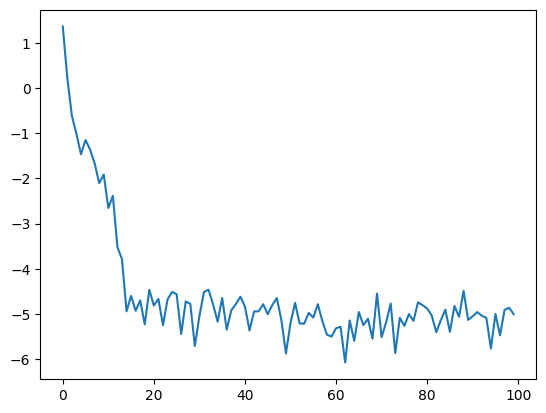

In [23]:
plt.plot(np.log(train_loss))

In [24]:
def get_strain_neoHook(x, Lambda_params): # Invert the get_stress_neoHook function to get the strain for a given stress
    sgmx = Fx/1.0 #stress is constant for the domain
    mu = nn_fpass(x, Lambda_params)
    
    invertsgm = lambda lmb: mu*lmb**2 - mu/lmb - sgmx
    lmb = fsolve(invertsgm, x0 = 1.0)
    return lmb-1.0

eps_pr = []
for i in range(len(x_gt)):
    eps_pr.append(get_strain_neoHook(x_gt[i,None], Lambda_params)[0])

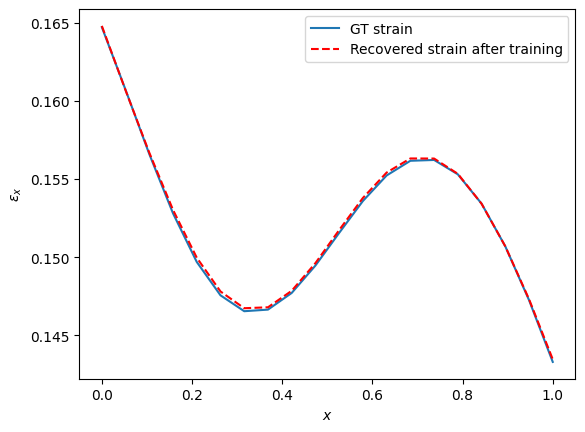

In [25]:
plt.plot(x_gt, eps_gt, label='GT strain')
plt.plot(x_gt, eps_pr, 'r--', label='Recovered strain after training')
plt.xlabel('$x$')
plt.ylabel('$\epsilon_{x}$')
plt.legend()

(0.4986922799015126, 0.7480384198522688)

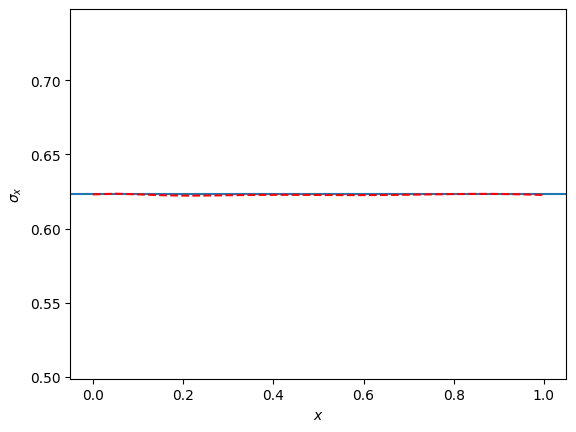

In [26]:
sgm_pr = []
for i in range(len(x_gt)):
    sgm_pr.append(get_stress_neoHook(x_gt[i,None], Lambda_params))
plt.axhline(Fx, label='GT stress')
plt.plot(x_gt, sgm_pr, 'r--', label='Stress calculated after training')
plt.xlabel('$x$')
plt.ylabel('$\sigma_{x}$')
plt.ylim([Fx*0.8, Fx*1.2])

#### Neural ODE

In [65]:
def get_stress_node(x, Lambda_params):
    eps = jnp.interp(x, x_gt, eps_gt)
    lmb = 1.0+eps
    I1 = lmb**2 + 1/lmb + 1/lmb
    phi = nn_fpass(x, Lambda_params)
    Psi1 = NODE(I1, unravel(phi))
    sgmx = Psi1*(lmb**2 - 1/lmb)
    return sgmx[0]
get_stress_node_vmap = vmap(get_stress_node, in_axes=(0,None), out_axes=(0,))
divergence_1d = vmap(grad(get_stress_node, argnums=0), in_axes=(0,None), out_axes=0)

def loss(Lambda_params, input, key):
    # get divergence across the domain
    x_colloc = random.uniform(key, (20,1))
    div = divergence_1d(x_colloc, Lambda_params)

    # get stress at 0 & L
    sgm0 = get_stress_node(x_gt[ 0,None], Lambda_params)
    sgmL = get_stress_node(x_gt[-1,None], Lambda_params)
    return 1*jnp.sum(div**2) + 10*((sgm0*1 - Fx)**2 + (sgmL*1-Fx)**2) # Assuming CS Area = 1


common_layers = [1,3,3]
sample_layers = [3,1]
clayers = init_layers(common_layers, key)
slayers = init_layers(sample_layers, key) # I don't really want to do common layers and sample layers here, but I didn't want to modify my functions to accept a single set of layers.
dummy_phi = (clayers, slayers) 
aux, unravel = ravel_pytree(dummy_phi)

n_params = len(aux)
Lambda_layers = [1,3,3,n_params]
key = random.PRNGKey(0)
Lambda_params = init_params_nn(Lambda_layers, key)

opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Lambda_params)

Lambda_params, train_loss, metrics = train_jp(loss, None, get_params, opt_update, opt_state, key, nIter = 200000, print_freq=10000)

it 10000, train loss = 1.395255e+01
it 20000, train loss = 8.939162e+00
it 30000, train loss = 4.445741e+00
it 40000, train loss = 1.421909e-01
it 50000, train loss = 2.096473e-02
it 60000, train loss = 2.143913e-02
it 70000, train loss = 1.395656e-02
it 80000, train loss = 1.118387e-02
it 90000, train loss = 1.332205e-02
it 100000, train loss = 8.574621e-03
it 110000, train loss = 1.167262e-02
it 120000, train loss = 9.645502e-03
it 130000, train loss = 1.197814e-02
it 140000, train loss = 7.487207e-03
it 150000, train loss = 6.431611e-03
it 160000, train loss = 5.431251e-03
it 170000, train loss = 4.315868e-03
it 180000, train loss = 5.841380e-03
it 190000, train loss = 2.191793e-03
it 200000, train loss = 5.048288e-03


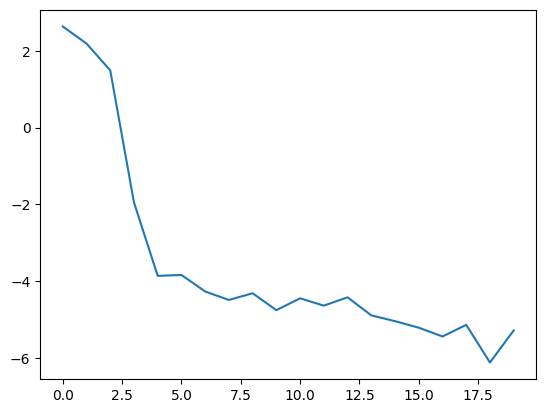

In [66]:
plt.plot(np.log(train_loss))

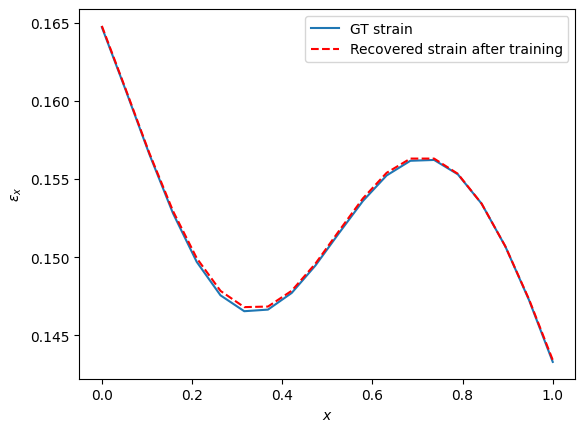

In [67]:
def get_strain_node(x, Lambda_params): # Invert the get_stress_neoHook function to get the strain for a given stress
    sgmx = Fx/1.0 #stress is constant for the domain
    phi = nn_fpass(x, Lambda_params)
    
    def invertsgm(lmb):
        I1 = lmb**2 + 1/lmb + 1/lmb
        Psi1 = NODE(I1, unravel(phi))
        return Psi1*(lmb**2 - 1/lmb) - sgmx
    lmb = fsolve(invertsgm, x0 = 1.0)
    return lmb-1.0

eps_pr = []
for i in range(len(x_gt)):
    eps_pr.append(get_strain_node(x_gt[i,None], Lambda_params)[0])


plt.plot(x_gt, eps_gt, label='GT strain')
plt.plot(x_gt, eps_pr, 'r--', label='Recovered strain after training')
plt.xlabel('$x$')
plt.ylabel('$\epsilon_{x}$')
plt.legend()

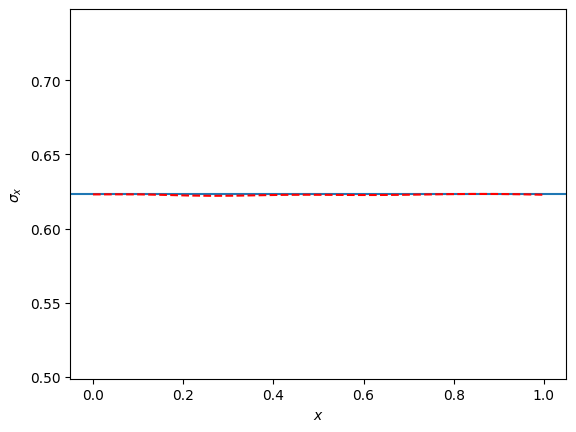

In [68]:
sgm_pr = []
for i in range(len(x_gt)):
    sgm_pr.append(get_stress_node(x_gt[i,None], Lambda_params))
plt.axhline(Fx, label='GT stress')
plt.plot(x_gt, sgm_pr, 'r--', label='Stress calculated after training')
plt.xlabel('$x$')
plt.ylabel('$\sigma_{x}$')
plt.ylim([Fx*0.8, Fx*1.2]); 